In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile as tiff 
from skimage.transform import resize

tf.config.experimental_run_functions_eagerly(True)
BASE_PATH = "../input/hubmap-organ-segmentation/"

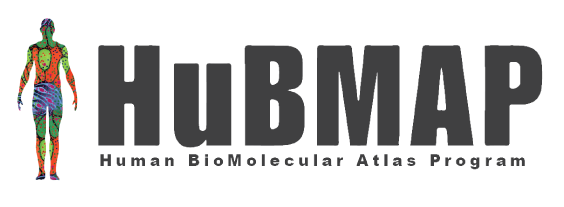 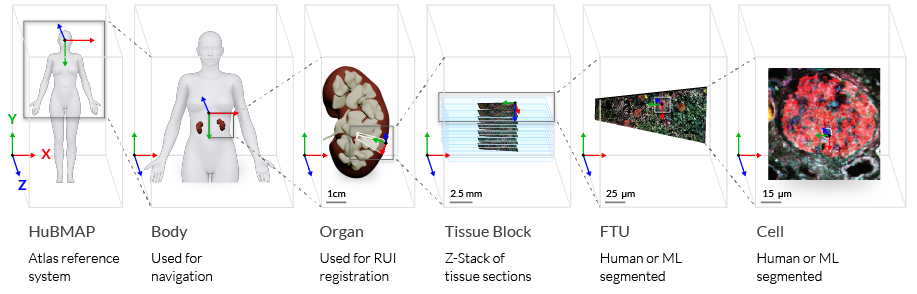

**For EDA and Loss Function - https://www.kaggle.com/code/muki2003/hubmap-tensorflow-eda-loss-function**

# **Meta and Image Data**

In [ ]:
train = pd.read_csv('../input/hubmap-organ-segmentation/train.csv')
test = pd.read_csv('../input/hubmap-organ-segmentation/test.csv')

In [ ]:
train

**Masking and Unmaksing Function**

In [ ]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

## **Resizing Image**

In [ ]:
img_id_1 = 9777
img_1 = tiff.imread(BASE_PATH + "train_images/" + str(img_id_1) + ".tiff")
print(img_1.shape)

In [ ]:
mask_1 = rle2mask(train[train["id"]==9777]["rle"].iloc[-1], (img_1.shape[1], img_1.shape[0]))
mask_1.shape

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img_1)
plt.imshow(mask_1, cmap='coolwarm', alpha=0.5)

In [ ]:
mask_1 = resize(mask_1, (428, 428, 1))
print(mask_1.shape)

img_1 = resize(img_1, (428, 428, 3))
print(img_1.shape)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(img_1)
plt.imshow(mask_1, cmap='coolwarm', alpha=0.5)

In [ ]:
plt.imshow(mask_1)

**Image Resige Augument and Normalize**

In [ ]:
def img_resize(input_image, input_mask):
    #input_image = tf.image.rgb_to_grayscale(input_image)
    input_image = resize(input_image, (128, 128, 3))
    input_mask = resize(input_mask, (128, 128))
    return input_image, input_mask

def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    #input_mask -= 1
    return input_image, input_mask


**Loading the Training and Testing Image**

In [ ]:
def load_image_train(datapoint):
    if(train.loc[train['id']==datapoint].index[0] % 25 == 0):
        print(train.loc[train['id']==datapoint].index[0], "Image Loaded out of 351")
        
    input_image = tiff.imread(BASE_PATH + "train_images/" + str(datapoint) + ".tiff")
    input_mask = rle2mask(train[train["id"]==datapoint]["rle"].iloc[-1], (input_image.shape[1], input_image.shape[0]))
    input_image, input_mask = img_resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [ ]:
train_dataset = train["id"].map(load_image_train)

print('\nAll 351 Images loaded !!')

In [ ]:
train_dataset[0]

# ------------------------------------------------------------------------------------ #

# **Main U-NET Model**

**Convolutational Neural Layers**

In [ ]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

In [ ]:
def build_model():
    inputs = layers.Input(shape=(128,128,1))

    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    bottleneck = double_conv_block(p4, 1024)

    u6 = upsample_block(bottleneck, f4, 512)

    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)


    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid", name="output")(u9)

    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

**U-NET Build**

In [ ]:
#model = build_model()

In [ ]:
#model.summary()

# ------------------------------------------------------------------------------------ #

# **PreTrained Segmentation Model**

In [ ]:
! pip install segmentation-models

In [ ]:
! pip install git+https://github.com/qubvel/segmentation_models

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

from segmentation_models import Unet
from segmentation_models.utils import set_trainable


model = Unet('efficientnetb0',input_shape=(128, 128, 3), classes=3, activation='sigmoid',encoder_weights='imagenet')
x = model.layers[-3].output

final_layer = layers.Conv2D(32, 1, padding="same", activation = "relu", name="final_conv2d")(x)
final_layer = layers.Conv2D(1, 1, padding="same", activation = "sigmoid", name="output")(final_layer)

model = tf.keras.Model(inputs = model.input, outputs = final_layer)

#model.summary()

# ------------------------------------------------------------------------------------ #

**Graph of Model**

In [ ]:
#tf.keras.utils.plot_model(model)

**Metric's and Loss Function**

In [ ]:
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

**Complie CNN Model**

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=bce_dice_loss, metrics=[dice_coef,iou_coef])

## **Model Training**

**Data Preparation For Training**

In [ ]:
X_train = []
y_train = []

In [ ]:
for i in train_dataset:
    X_train.append(i[0])
    y_train.append(i[1].reshape(128,128,1))

In [ ]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(49):
    ax = plt.subplot(7, 7, i + 1)
    plt.imshow(X_train[i] * 255.)
    plt.imshow(y_train[i], cmap='coolwarm', alpha=0.65)
    plt.axis("off")

In [ ]:
save_best = tf.keras.callbacks.ModelCheckpoint("Model.h5", monitor='val_dice_coef',save_best_only=True, verbose=1)

In [ ]:
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16, shuffle=True, callbacks=[save_best])

### **Predication Mask**

In [ ]:
model = tk.keras.models.load_model('./Model.h5')

In [ ]:
Pred = model.predict(X_train, verbose=1)

In [ ]:
Pred.shape

#### **Orginal VS Predicted**

In [ ]:
# Orginal Image and Mask
plt.figure(figsize=(20, 20))
for i in range(5):
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.title('Orginal')
    #plt.imshow(X_train[i] * 255.)
    plt.imshow(y_train[i], cmap='coolwarm', alpha=0.5)
    plt.subplot(1, 2, 2)
    plt.title('Predicted')
    #plt.imshow(X_train[i] * 255.)
    plt.imshow(Pred[i], cmap='coolwarm', alpha=0.5)


# ***Work in Progress........ !!***